# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('src')

import pint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('precision', 5)

import codetimer as ct
import GLE_simulation_ND as gle

In [2]:
np.set_printoptions(edgeitems=5, precision=5)

In [2]:
ur = pint.UnitRegistry()

In [3]:
def per_mol(Q, units=None):
    if not units:
        units = Q.units
    return (Q * ur.avogadro_number).to(units/ur.mol)

def mass_particle(r, rhop, unit=ur.kg):
    return (rhop*(4./3.)*np.pi*r**3).to(unit)

def t_units(m, r, eta, rhof, unit=ur.s):
    return ((m / (3*np.pi*r**2*(eta*rhof)**0.5))**2).to(unit)

def x_units(x, unit=ur.m):
    return x.to(unit)

def v_units(x, t, unit=ur.m/ur.s):
    return (x/t).to(unit)

def F_units(m, x, t, unit=ur.N):
    return (m*(x/t**2)).to(unit)

def E_units(m, x, t, unit=ur.J):
    return (m*(x/t)**2).to(unit)

In [4]:
eta = 1.0042e-3 * ur.kg/ur.m/ur.s
rhop = 1.0 * ur.g/ur.cm**3
rhof = 1.0 * ur.g/ur.cm**3
R = 10.0 * ur.nm

In [5]:
m = mass_particle(R, rhop, unit=ur.pg)
t0 = t_units(m, R, eta, rhof, unit=ur.ns)
x0 = x_units(R, unit=ur.um)
v0 = v_units(x0, t0, unit=ur.um/ur.ns)
F0 = F_units(m, x0, t0, unit=ur.uN)
E0 = E_units(m, x0, t0, unit=ur.kJ)
print m
print t0
print x0
print v0
print F0
print per_mol(E0, units=ur.kJ)

4.18879020479e-06 picogram
0.0196704704439 nanosecond
0.01 micrometer
0.50837625 micrometer / nanosecond
0.108257779722 micronewton
651943.645229 kilojoule / mole


In [ ]:
R = 100.0 * ur.nm
Rp = (R / x0).to('dimensionless')
print R
print Rp.magnitude

---

# Langevin Impulse-based integrator

The Langevin Impulse (LI) integrator is the "SD" (stochastic dynamics) integrator used in GROMACS (and also GROMOS). It is an "impulsive Langevin" extension to the familiar leap-frog algorithm. Though the authors state at the outset that they seek an algorithm that is of the same order of accuracy as the Verlet-type algorithms, though it's not clear whether this stochastic algorithm is truly correct to second order in the timestep, $\mathcal{O}(\Delta t^2)$.

Primary reference: [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876)

See also: [R. D. Skeel & J. A. Izaguirre (2002), Mol. Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/0026897021000018321)

---

---
## Test Langevin Impulse integration

In [47]:
res = pint.pi_theorem({
    'V': '[length]/[time]',
    'T': '[time]',
    'L': '[length]'
})
for DQ in res:
    print(pint.formatter(DQ.items()))

res2 = ur.pi_theorem({
    'P': '[pressure]',
    'L': '[length]',
    'D': '[length]',
    'RHO': '[mass]/[volume]',
    'ETA': '[viscosity]',
    'V': '[speed]'
})
for DQ in res2:
    print(pint.formatter(DQ.items()))

T * V / L
D / L
L ** 2 * P * RHO / ETA ** 2
ETA * V / L / P


**Siegle's _EPL_ paper: dimensional scaling**

```
Lc  = 1e-08 m
Mc  = 4.18879020479e-21 kg
Tc  = 1.96704704439e-11 s
Nc  = 4188.79020479 kg/m^3
Vc  = 508.37625 m/s
Ec  = 1.08257779722e-15 kg(m/s)^2
Fc  = 1.08257779722e-07 kg m/s^2
Tec = 78410819.0623 K
```

**Siegle's _PRL_ paper: dimensional scaling**

In [32]:
kB = 1.3806485e-23
N = 1
eta = 1.0042e-3
rhof = 1.0e3
rhop = 1.0e3
R = 1.0e-7
gam0 = 1.0e11                         # collision frequency
m = rhop*(4./3.)*np.pi*R**3           # particle mass
### Dimensional units ##
Lc = R                                         # length
Tc = 1./gam0                                   # time
Ec = m*(Lc/Tc)**2                              # energy
### Derived units ##
Vc  = Lc/Tc                                    # velocity
Mc  = Ec/Vc**2                                 # mass
Nc  = Mc/Lc**3                                 # density
Fc  = Ec/Lc                                    # force
Tec = Ec/kB                                    # temperature

```
Lc  = 1e-08 m
Mc  = 4.18879020479e-21 kg
Tc  = 1e-11 s
Nc  = 4188.79020479 kg/m^3
Vc  = 1000.0 m/s
Ec  = 4.18879020479e-15 kg(m/s)^2
Fc  = 4.18879020479e-07 kg m/s^2
Tec = 78410819.0623 K
```

In [33]:
print 'Lc  =', Lc, 'm'
print 'Mc  =', Mc, 'kg'
print 'Tc  =', Tc, 's'
print 'Nc  =', Nc, 'kg/m^3'
print 'Vc  =', Vc, 'm/s'
print 'Ec  =', Ec, 'kg(m/s)^2'
print 'Fc  =', Fc, 'kg m/s^2'
print 'Tec =', Tec, 'K'

Lc  = 1e-07 m
Mc  = 4.18879020479e-18 kg
Tc  = 1e-11 s
Nc  = 4188.79020479 kg/m^3
Vc  = 10000.0 m/s
Ec  = 4.18879020479e-10 kg(m/s)^2
Fc  = 0.00418879020479 kg m/s^2
Tec = 3.03392949385e+13 K


## Attempt integration of Langevin-Impulse-based Extended Langevin dynamics

In [75]:
T = 300        # [K]
nu1 = 2.5e10   # [1/s]
k = 1.0e-3     # [N/m] = [kg/s^2]
dt = 1.0e-16   # [s]

In [81]:
gli_sim.Xout.close()
gli_sim.Vout.close()
gli_sim.Sout.close()

In [87]:
gli_sim.Xout

<class 'pandas.io.pytables.HDFStore'>
File path: data/ELI_newtest.pos.h5

In [84]:
gli_sim = gle.GLEParticle(filename='data/ELI_newtest', method='ELI',
                         N=N, D=3, T=T, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, k=k, dt=dt)

Settings parameters for ELI integrator


ValueError: The file 'data/ELI_newtest.pos.h5' is already opened.  Please close it before reopening in write mode.

In [36]:
with ct.Timer(unit='secs') as t:
    gli_sim.run(nsteps=10000, tmpsize=10000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 10000 (100.0% complete) – elapsed time: 0.6 s


In [37]:
gli_sim.positions

x1           y1        z1
1.0      0.00000e+00  0.00000e+00   0.00000
2.0     -1.22885e-06  6.63753e-06  -0.00003
3.0     -1.24857e-05  6.41996e-05  -0.00007
4.0     -2.88254e-05  1.84429e-04  -0.00011
5.0     -2.04483e-05  3.59935e-04  -0.00021
6.0      1.39207e-05  5.61049e-04  -0.00038
7.0      5.74887e-05  7.24383e-04  -0.00060
8.0      9.52888e-05  9.08548e-04  -0.00086
9.0      9.35048e-05  1.10463e-03  -0.00110
10.0     1.71481e-05  1.25087e-03  -0.00126
11.0    -7.14818e-05  1.40289e-03  -0.00140
12.0    -1.08216e-04  1.57710e-03  -0.00157
13.0    -8.10368e-05  1.71670e-03  -0.00169
14.0     8.86917e-06  1.83971e-03  -0.00176
15.0     9.15086e-05  2.05847e-03  -0.00184
...              ...          ...       ...
9986.0   4.30022e+01  4.07682e+01 -20.28890
9987.0   4.30117e+01  4.07759e+01 -20.28919
9988.0   4.30211e+01  4.07835e+01 -20.28952
9989.0   4.30305e+01  4.07911e+01 -20.28984
9990.0   4.30400e+01  4.07987e+01 -20.29021
9991.0   4.30494e+01  4.08063e+01 -20.29060
9992.0   4.30587e+01  4.08140e+01 -20.29100
9993.0   4.30681e+01  4.08217e+01 -20.29133
9994.0   4.30775e+01  4.08295e+01 -20.29156
9995.0   4.30870e+01  4.08373e+01 -20.29170
9996.0   4.30965e+01  4.08451e+01 -20.29178
9997.0   4.31060e+01  4.08528e+01 -20.29174
9998.0   4.31155e+01  4.08605e+01 -20.29159
9999.0   4.31250e+01  4.08681e+01 -20.29137
10000.0  4.31345e+01  4.08757e+01 -20.29108

[10000 rows x 3 columns]

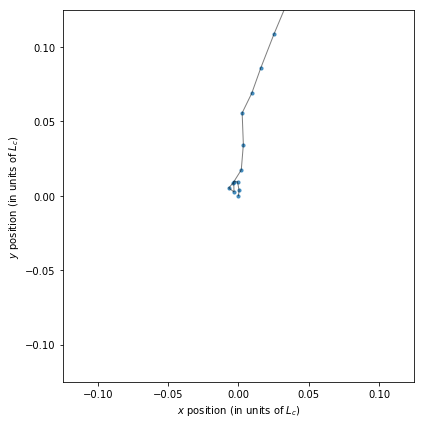

In [67]:
plt.clf()
scale = 0.125
lims = scale*np.vstack((-np.ones(3), np.ones(3))).T
fig, ax = gli_sim.quick_plot(step=20, lims=lims, figsize=6.0)

## Assumed dynamical form

The generalized Langevin dynamics (GLD) equation of motion is represented in the extended/auxiliary variable formalism by the following set of coupled, first-order SDEs:

$$
\dot{x} = v(t)
$$

$$
\dot{v} = \frac{1}{m}F(x(t)) - \frac{1}{m}\sum_{k=1}^N \sigma_k(t) - \frac{c_0}{m}\:\! v(t) + \hat{\xi}_0(t),
$$

$$
\dot{\sigma}_k = -\frac{1}{\tau_k}\sigma_k(t) - \frac{c_k}{\tau_k}v(t) + \frac{1}{\tau_k}\hat{\xi}_k(t)
$$

where $x$, $v$, and $m$ are, respectively, the main particle's position, velocity and mass, $c_0 = \sum c_k$ with $\gamma_0 = c_0/m = 1/\tau_0$ being the collision frequency for the main particle, $\gamma_k = c_k/m = 1/\tau_k$ is the collision frequency for auxiliary particle $k$, and $\hat{\xi}_0$ and $\hat{\xi}_k$ are thermal noise terms for the main and $k^\text{th}$ particle, respectively. There are $N$ auxiliary particles, each subject to an independent noise process, $\xi_k$; $\hat{\xi}_0$ and $\hat{\xi}_k$ describe $N+1$ zero-mean, white Gaussian noise processes with autocorrelations given by

$$
\left\langle\xi_0(t)\xi_0(t')\right\rangle = \sum_{k=1}^N \frac{2k_BT c_k}{m}\delta(t-t').
$$

$$
\left\langle\xi_k(t)\xi_k(t')\right\rangle = \frac{2k_BT c_k}{\tau_k^2}\delta(t-t').
$$

Since $\xi_0$ is calculated from a weighted sum of the $\xi_k$, the $N$ auxiliary noise processes, there are $N$ independent stochastic samples required per timestep.

## Numerical discretization


### Langevin Impulse approach

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

$$
v_\text{LF}^{n+1/2} = v^{n-1/2} + \frac{\Delta t}{m}\left[F(x^n) - \sum_{k=1}^N \sigma_k^n\right]
$$

$$
\Delta v = -(1-\theta_0)\:\! v_\text{LF}^{n+1/2} + \sqrt{(1-\theta_0^2)\:\!\frac{k_BT}{m}} \,\mathcal{W}_0^n
$$

$$
x^{n+1} = x^n + \Delta t\left(v_\text{LF}^{n+1/2} + \frac{1}{2}\Delta v\right)
$$

$$
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!c_k v_\text{LF}^{n+1/2} + \sqrt{\frac{(1-\theta_k^2)}{\tau_k}c_k k_BT} \,\mathcal{W}_k^n
$$

$$
v^{n+1/2} = v_\text{LF}^{n+1/2} + \Delta v
$$

where

$$
\theta_0 = e^{-c_0 \Delta t/m} = e^{-\Delta t/\tau_0} = e^{-\gamma_0 \Delta t} \qquad \text{and} \qquad \theta_k = e^{-\Delta t/\tau_k}.
$$

Note that $\mathcal{W}_k^n$ is a zero-mean, unit variance white noise process sampled independently of the other noises at each timestep, $n$, while $\mathcal{W}_0^n$ is a weighted sum of the $N$ independent white noises. Also note that $v_\text{LF}$ is the usual MD velocity update for the leap-frog scheme, which now includes the "auxiliary forces", $\sigma_k$. The _effective collision frequency_<sup>[2](#footnote2)</sup> of particle $k$ is given by $1/\tau_k$, and $0 \leq (1 -\theta_k) \leq 1$ is a _velocity reduction factor_ that scales the impulsive application of friction and noise.

**Notes**:

<a name="footnote1">1</a>: For some reason, the [GROMACS manual](http://manual.gromacs.org/documentation/2018/manual-2018.pdf) specifies the noise term with $\sqrt{(1-\alpha^2)k_BT/m}$ rather than $\sqrt{\alpha(2-\alpha)k_BT/m}$ as specified in [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876). The GROMACS definition makes somewhat _less_ sense to me when considering the series expansion in powers of small $\gamma\Delta t$, though I'm not sure whether there's simply a typo in the manual or they're using a different definition. For the latter expression ($\sqrt{\alpha(2-\alpha)k_BT/m}$, where $\alpha = 1 - \exp(-\gamma_0\Delta t)$), it can be easily seen that $(1-\theta_0) = \alpha$ and $(1-\theta_0^2) = \alpha(2-\alpha)$

<a name="footnote2">2</a>: From what I currently understand, $\gamma_0 = 1/\tau_0$ is the collision frequency that results from discretizing the noise and friction in the system using $(1-\theta_0)$. It makes sense, however, that when $\Delta t/\tau_0 \ll 1$, we have $(1-\theta_0) = \Delta t/\tau_0 + \mathcal{O}(\Delta t^2)$ and $(1-\theta_0^2) = 2\Delta t/\tau_0$, which leads to

$$
\Delta v = -\frac{\Delta t}{\tau_0}\:\! v_\text{LF}^{n+1/2} + \sqrt{\frac{2 k_BT\Delta t}{\tau_0 m}} \,\mathcal{W}_0^n
$$

---

---

# Grønbech-Jensen–Farago integrator

This integrator is described by the authors as "a revision to the well known Störmer–Verlet algorithm for simulating second order differential equations. The revision addresses the inclusion of linear friction with associated stochastic noise, and we analytically demonstrate that the new algorithm correctly reproduces diffusive behavior of a particle in a flat potential." The algorithm is correct to second order in the timeste, $\mathcal{O}(\Delta t^2)$.

Reference: [N. Grønbech-Jensen  & O. Farago (2013). Mol.Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/00268976.2012.760055)

---

## Assumed dynamical form

The equation of motion is a second-order SDE of the Langevin type:

$$
\dot{x} = v(t)
$$

$$
m\dot{v} = F(x(t)) - m\:\!\gamma\:\! v(t) + \beta(t),
$$

where $m$ is the particle mass, $\gamma = \zeta/m$ is the collision frequency, $\zeta$ is the usual friction coefficient, and the noise autocorrelation is given by

$$
\left\langle\beta(t)\beta(t')\right\rangle = 2m\:\!\gamma \:\!k_BT\:\!\delta(t-t').
$$

## Numerical discretization

First, we note that the autocorrelation is expressed in terms of the time step (just like in the first-order BBK algorithm),

$$
\left\langle\beta^n\beta^m\right\rangle = 2m\:\!\gamma \:\!k_BT\Delta t\:\!\delta_{nm},
$$

which will be used in the expressions that follow. The numerical algorithm is given by

$$
x^{n+1} = x^n + \alpha\Delta t\:\! v^n + \frac{ \alpha\Delta t^2}{2m}F(x^n) + \frac{\alpha\Delta t}{2m}\beta^{n+1}
$$

$$
v^{n+1} = v^n + \frac{\Delta t}{2m}\left[F\left(x^n\right) + F\left(x^{n+1}\right)\right] - \gamma\left(x^{n+1} - x^n\right) + \frac{1}{m}\beta^{n+1}
$$

where

$$
\alpha = \frac{1}{1 + \frac{\gamma\Delta t}{2}},
$$

where the timestep must be sufficiently small to satisfy $\gamma\Delta t < 2$. Using the substitution $F(x^n) = F^n$ along with $\beta^n = \sqrt{2m\:\!\gamma \:\!k_BT\Delta t}\:\! \mathcal{W}^n$, where $\mathcal{W}$ is a zero-mean, unit-variance white noise, we can rewrite the above discretization as

$$
\Delta x = \alpha\Delta t\left(v^n + \frac{\Delta t}{2m}F^n + \frac{1}{2}\sqrt{\frac{2\gamma\:\!k_BT \Delta t}{m}}\,\mathcal{W}^{n+1}\right)
$$

$$
x^{n+1} = x^n + \Delta x
$$

$$
v^{n+1} = v^n - \gamma\Delta x + \frac{\Delta t}{2m}\left(F^n + F^{n+1}\right) + \sqrt{\frac{2\gamma\:\!k_BT\Delta t}{m}}\,\mathcal{W}^{n+1}
$$

---
## Test Grønbech-Jensen–Farago integration

In [5]:
gjf_sim = langevin.LangevinParticle(filename='data/GJF_newtest', method='GJF',
                            N=1, D=3, T=1, m=100.0, gamma=1.0, k=0.0, dt=1.0)

Settings parameters for GJF integrator


In [6]:
with ct.Timer(unit='secs') as t:
    gjf_sim.run(nsteps=100000, tmpsize=100000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 100000 (100.0% complete) – elapsed time: 2.8 s


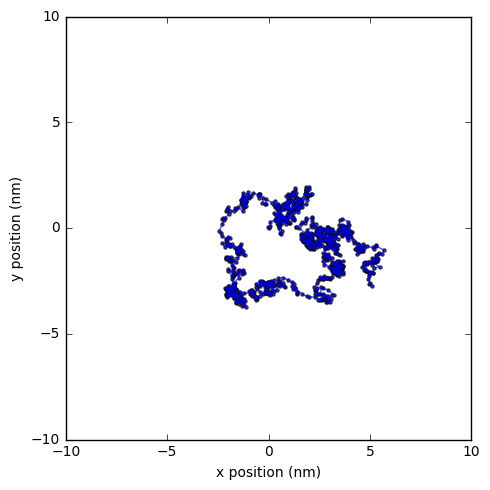

In [7]:
plt.clf()
fig, ax = gjf_sim.quick_plot(projection=None, start=0, end=None, skip=100,
                              xlim=[-10,10], ylim=[-10,10], zlim=[-10,10],
                              figsize=5.0, ptsize=5)

---

---

---

### T = 0 | N = 8

In [2]:
sim31_8_0 = md.MD(outfile='traj3-1_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim32_8_0 = md.MD(outfile='traj3-2_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim33_8_0 = md.MD(outfile='traj3-3_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim34_8_0 = md.MD(outfile='traj3-4_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim35_8_0 = md.MD(outfile='traj3-5_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim36_8_0 = md.MD(outfile='traj3-6_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)

### T = 300 | N = 8

In [3]:
sim31_8_300 = md.MD(outfile='traj3-1_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim32_8_300 = md.MD(outfile='traj3-2_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim33_8_300 = md.MD(outfile='traj3-3_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim34_8_300 = md.MD(outfile='traj3-4_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim35_8_300 = md.MD(outfile='traj3-5_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim36_8_300 = md.MD(outfile='traj3-6_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)

## Run simulations

### T = 0 K , N = 8

# 0

In [4]:
with ct.Timer(unit='secs') as t:
    sim31_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 130000 (13.0% complete) – elapsed time: 13.4 s
Step 130000 (13.0% complete) – elapsed time: 15.9 s
Step 130000 (13.0% complete) – elapsed time: 14.4 s
Step 130000 (13.0% complete) – elapsed time: 14.6 s
Step 130000 (13.0% complete) – elapsed time: 15.6 s
Step 130000 (13.0% complete) – elapsed time: 16.2 s


### T = 300 K , N = 8

# 300

In [5]:
with ct.Timer(unit='secs') as t:
    sim31_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 420000 (42.0% complete) – elapsed time: 45.7 s
Step 230000 (23.0% complete) – elapsed time: 24.6 s
Step 540000 (54.0% complete) – elapsed time: 59.3 s
Step 430000 (43.0% complete) – elapsed time: 49.8 s
Step 340000 (34.0% complete) – elapsed time: 37.7 s
Step 680000 (68.0% complete) – elapsed time: 69.5 s


# Raw data

We can view the trajectory output directly. It's a pandas DataFrame stored persistently in HDF5 format.

# Plotting

## T = 0 K , N = 8

### XY plots

In [ ]:
s = 0
sim31_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)

### YZ plots

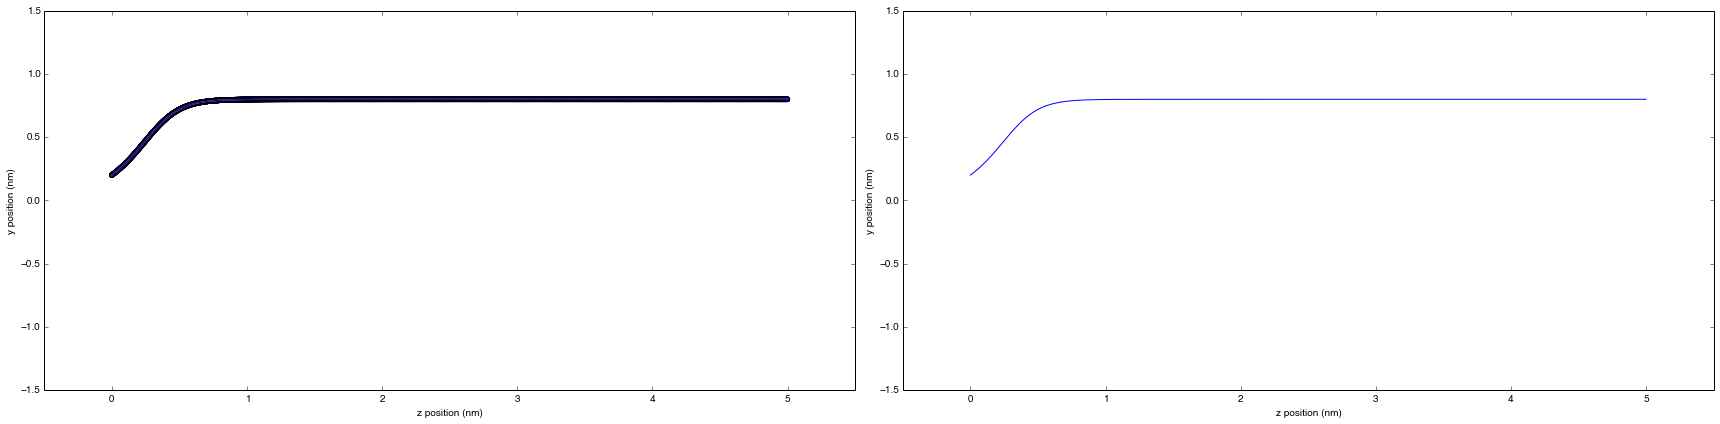

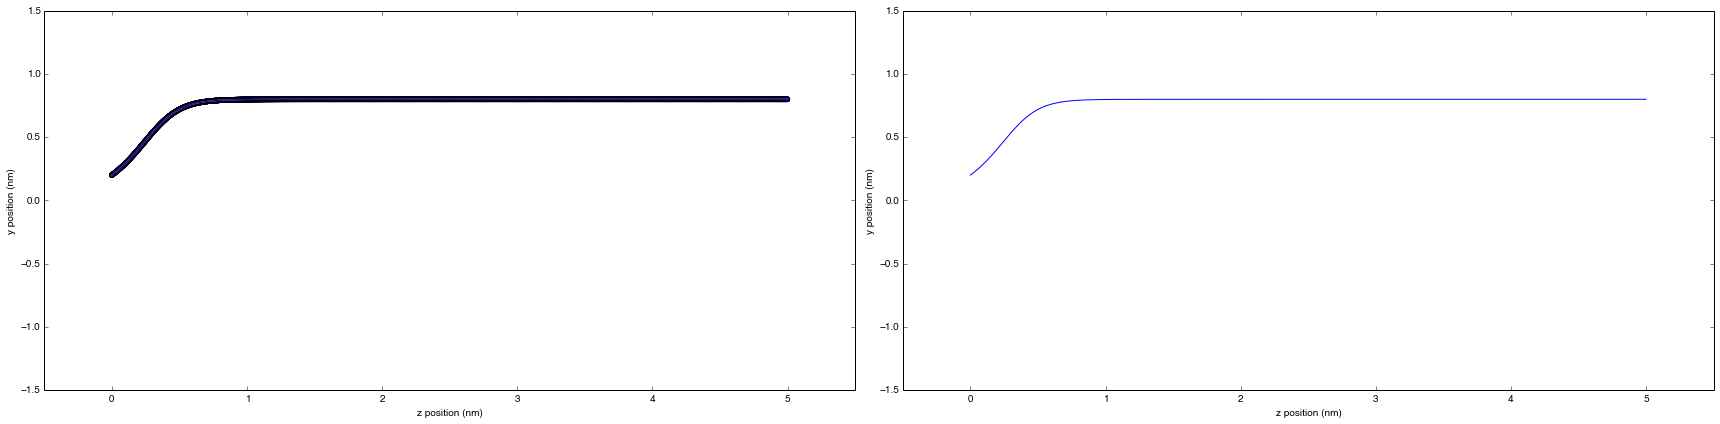

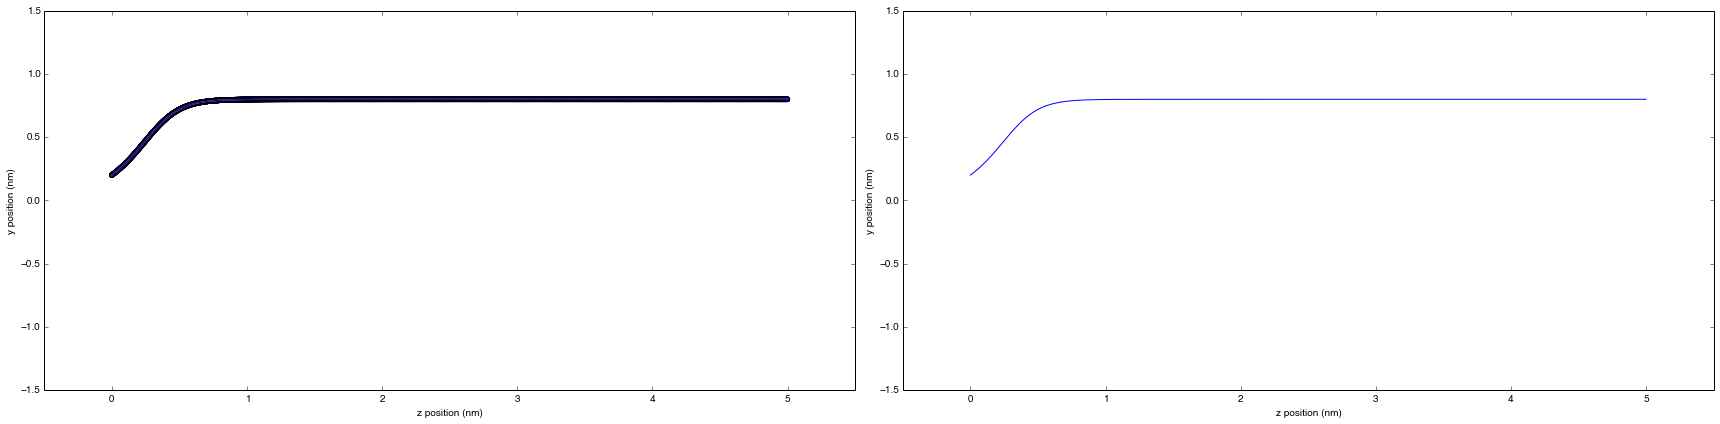

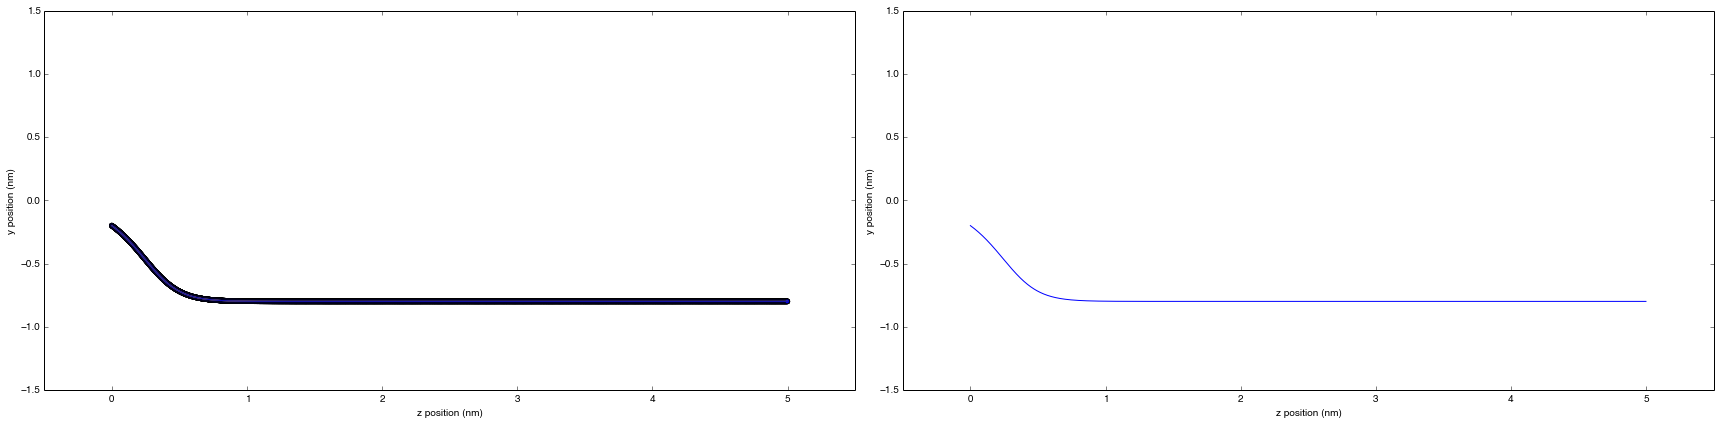

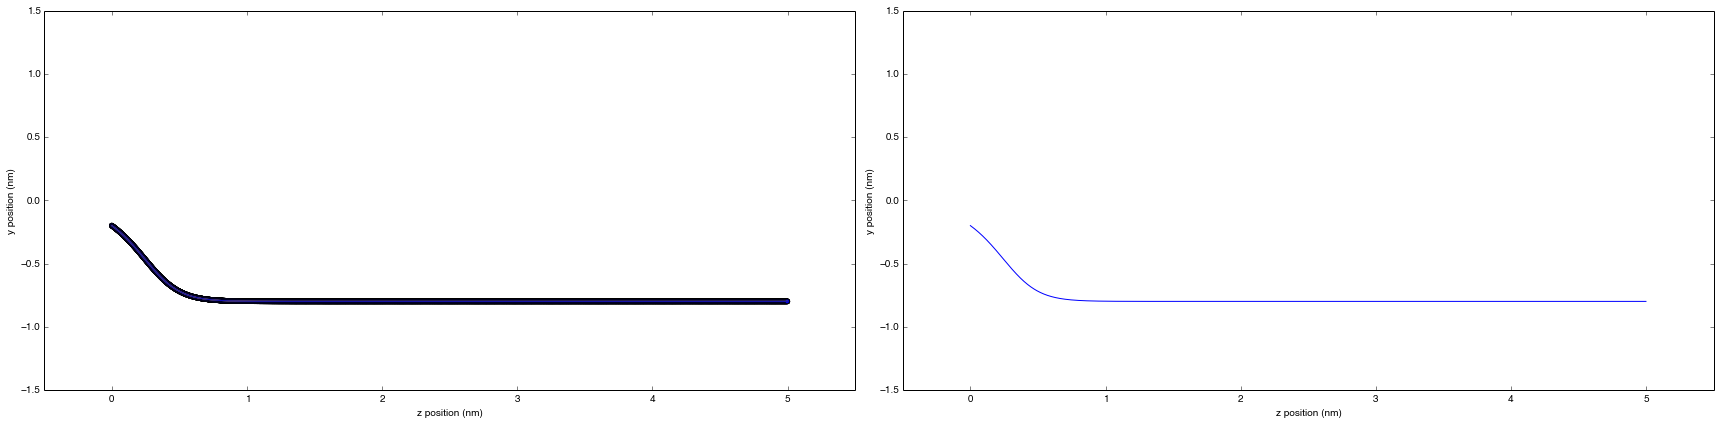

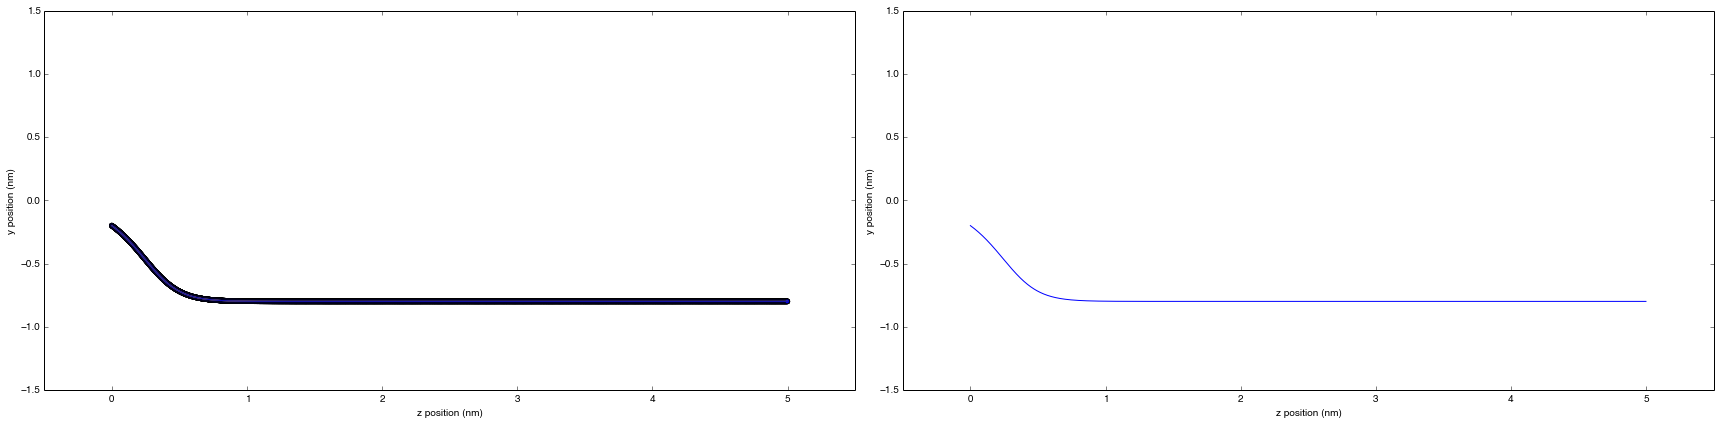

In [6]:
s = 0
sim31_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)

## T = 300 K , N = 8

### XY plots

In [ ]:
sim.plot_trajectories(projection='xy', skip=1000)

### YZ plots

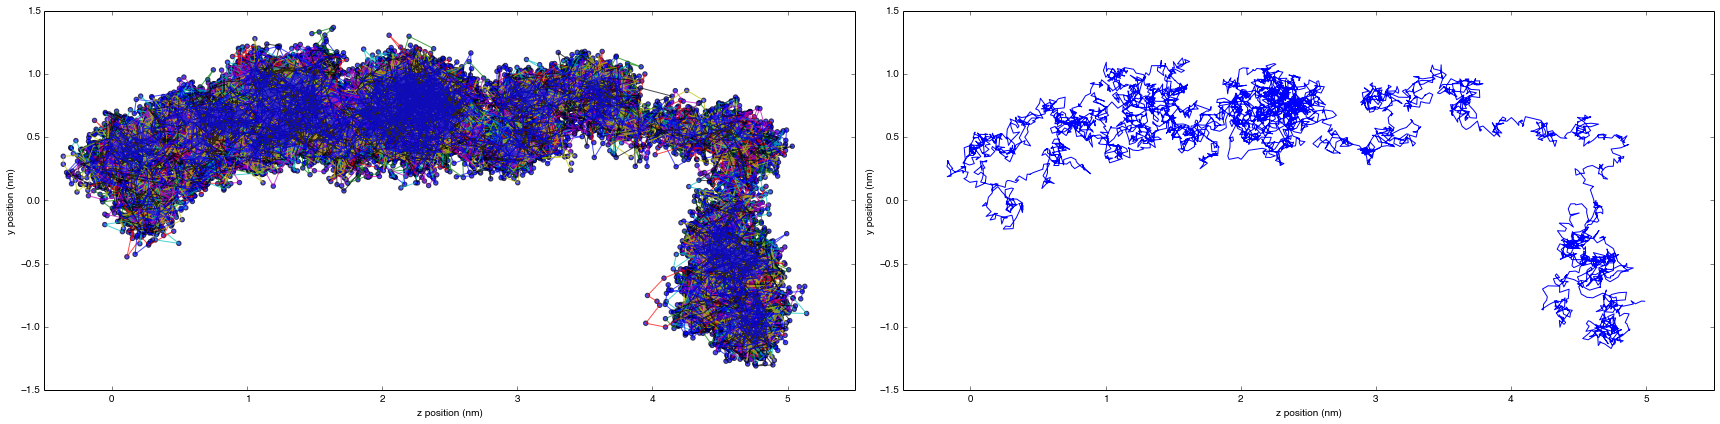

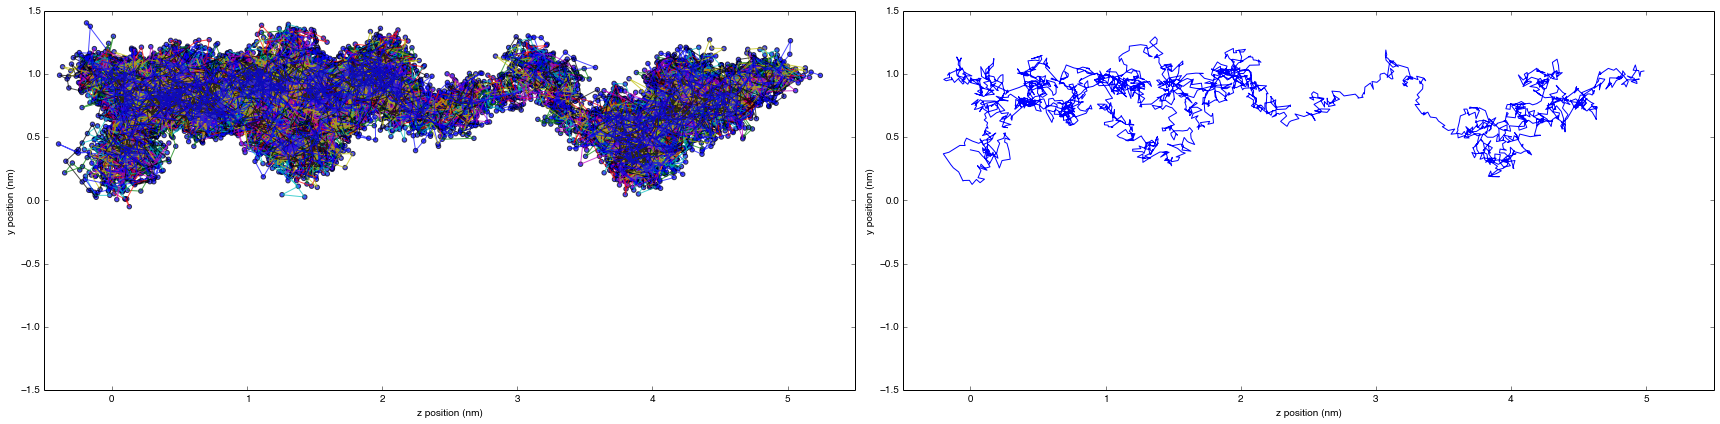

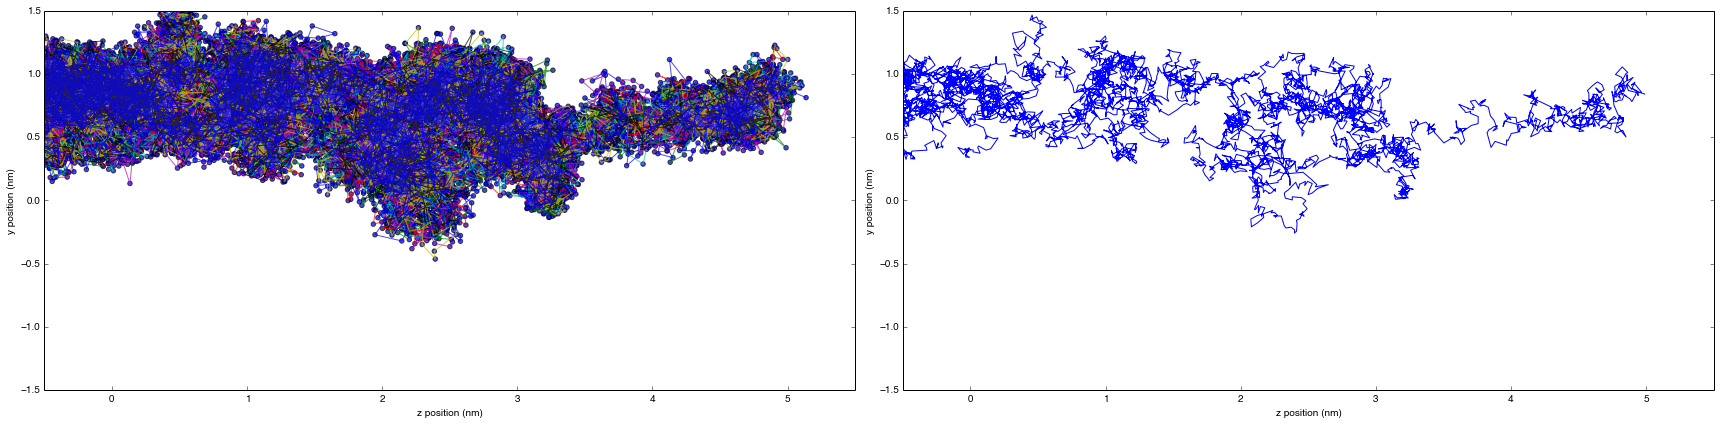

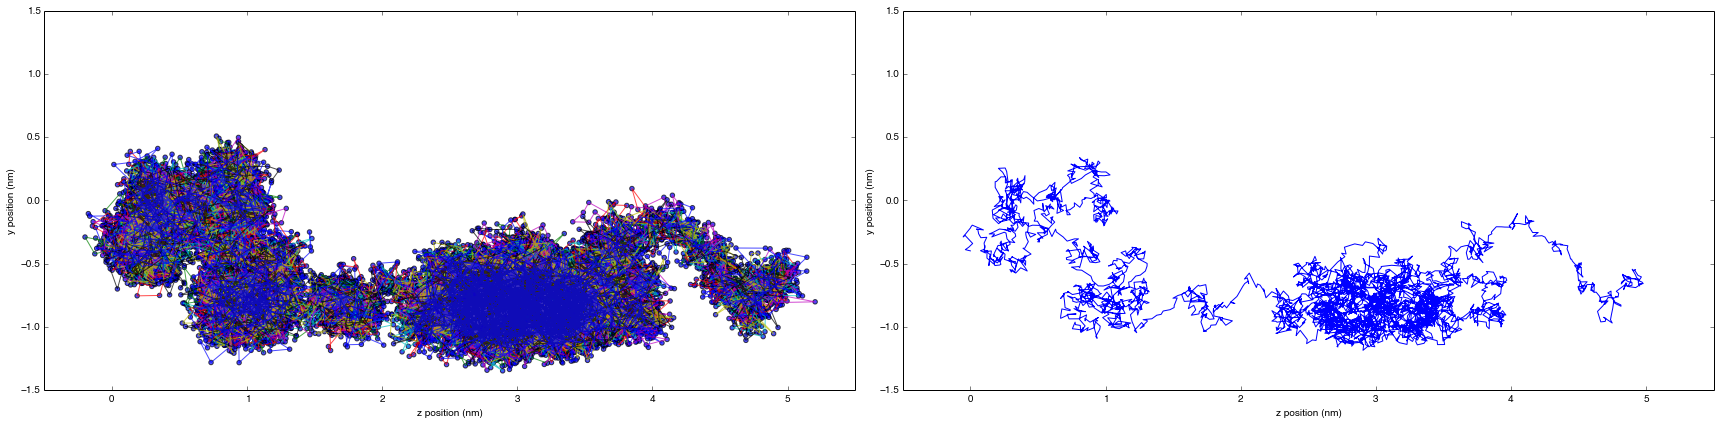

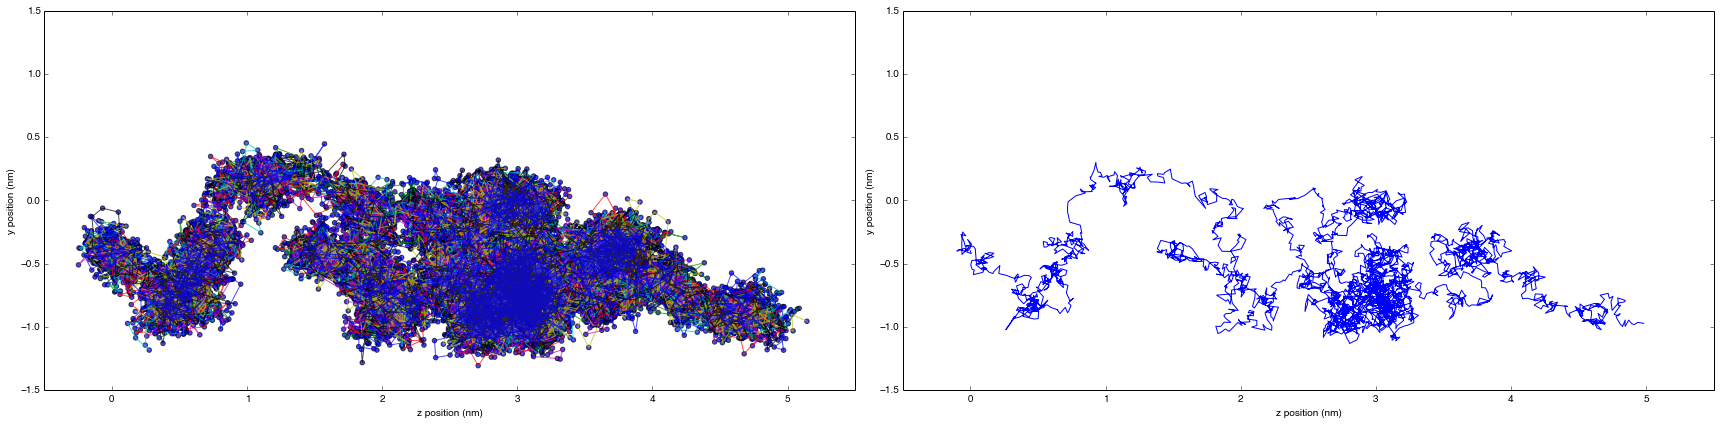

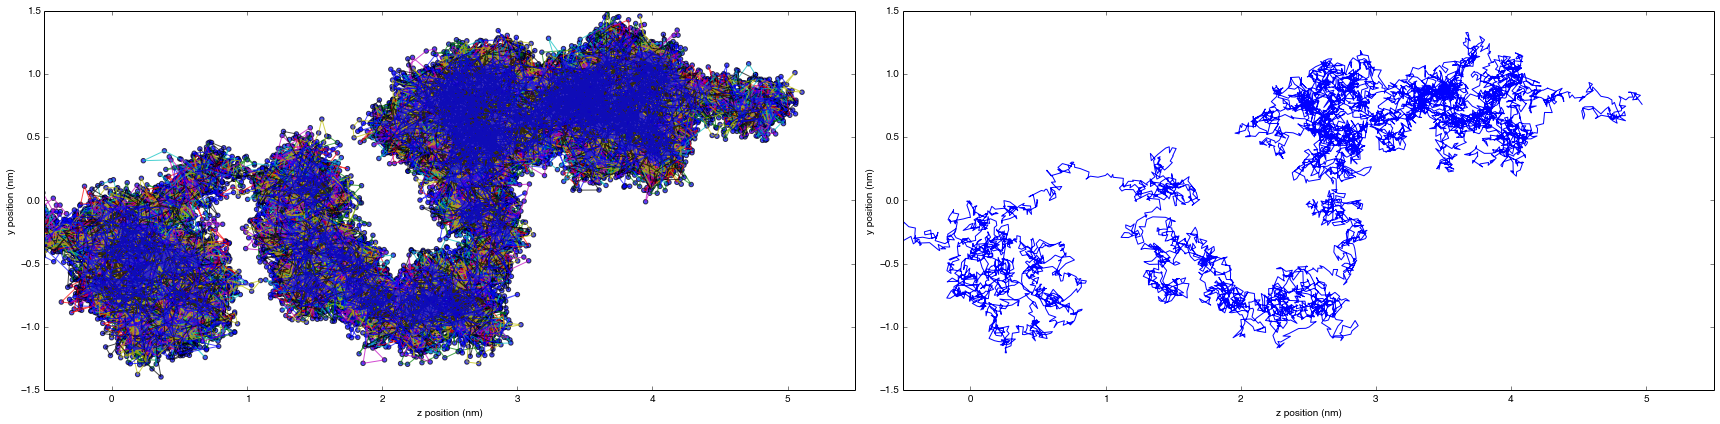

In [8]:
s=0
sim31_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)

In [68]:
simtest.compute_particle_size()

(array([ 0.22106883,  0.21892975,  0.21886752]),
 0.38040065270089218,
 0.21962203501782554,
 0.38961259711579105)

In [69]:
simtest2.compute_particle_size()

(array([ 0.22004685,  0.22021797,  0.22240095]),
 0.38259475816196803,
 0.22088858691080987,
 0.391798958433341)

In [10]:
sim31_8_0.compute_rog()

AttributeError: 'MD' object has no attribute 'compute_rog'